## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

import plotly.express as px
import plotly.graph_objects as go

sns.set()

## Load Data

In [2]:
# The supplied CSV data file is the DataSet directory
weather_df = pd.read_csv('../clean_data/weather_df.csv')
spray_df = pd.read_csv('../data/spray.csv')
train_df = pd.read_csv('../clean_data/train_df.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
weather_df['Date'] = weather_df['Date'].apply(pd.to_datetime)

In [4]:
# Split waether data into Station 1 and Station 2
weather_df1 = weather_df.loc[weather_df['Station']==1]
weather_df2 = weather_df.loc[weather_df['Station']==2]

In [5]:
# Get Station data into ohare and midway dictionary
keys = ['Latitude','Longitude', 'SeaLevel']

ohare_val = [41.995, -87.933, 662]
midway_val = [41.786, -87.752, 612]

Station1 = dict(zip(keys, ohare_val))
Station2 = dict(zip(keys, midway_val))

In [6]:
weather_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 1 to 2943
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1472 non-null   datetime64[ns]
 1   Station      1472 non-null   int64         
 2   Tmax         1472 non-null   int64         
 3   Tmin         1472 non-null   int64         
 4   Tavg         1472 non-null   float64       
 5   DewPoint     1472 non-null   int64         
 6   WetBulb      1472 non-null   float64       
 7   Heat         1472 non-null   float64       
 8   Cool         1472 non-null   float64       
 9   Sunrise      1472 non-null   int64         
 10  Sunset       1472 non-null   int64         
 11  PrecipTotal  1472 non-null   float64       
 12  StnPressure  1472 non-null   float64       
 13  SeaLevel     1472 non-null   float64       
 14  ResultSpeed  1472 non-null   float64       
 15  ResultDir    1472 non-null   int64         
 16  AvgSpe

In [7]:
def create_shiftdata(df, var, shift_val, label):
    
    for i, val in enumerate(shift_val, start = 1):
        df[f'{label}{i}'] = df[var].shift(val)
    return df

In [8]:
create_shiftdata(weather_df1, 'Tavg', [1, 2, 7, 14], 'Tvaglag');
create_shiftdata(weather_df1, 'PrecipTotal', [1, 2, 7, 14], 'PTotallag');

create_shiftdata(weather_df2, 'Tavg', [1, 2, 7, 14], 'Tvaglag');
create_shiftdata(weather_df2, 'PrecipTotal', [1, 2, 7, 14], 'PTotallag');



/var/folders/rt/9nm_7gz557x94zz8z2yl0fgm0000gn/T/ipykernel_22161/2412931074.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{label}{i}'] = df[var].shift(val)


In [9]:
weather_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 2942
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1472 non-null   datetime64[ns]
 1   Station      1472 non-null   int64         
 2   Tmax         1472 non-null   int64         
 3   Tmin         1472 non-null   int64         
 4   Tavg         1472 non-null   float64       
 5   DewPoint     1472 non-null   int64         
 6   WetBulb      1472 non-null   float64       
 7   Heat         1472 non-null   float64       
 8   Cool         1472 non-null   float64       
 9   Sunrise      1472 non-null   int64         
 10  Sunset       1472 non-null   int64         
 11  PrecipTotal  1472 non-null   float64       
 12  StnPressure  1472 non-null   float64       
 13  SeaLevel     1472 non-null   float64       
 14  ResultSpeed  1472 non-null   float64       
 15  ResultDir    1472 non-null   int64         
 16  AvgSpe

### Merge Train data with weather data

In [10]:
# Lets craete a column on train data that shows distance from station 1 and station 2
train_df = pd.read_csv('../data/train.csv')


In [11]:
train_df['Date'] = train_df['Date'].apply(pd.to_datetime)

In [12]:
# Source Stack Overflow
import math

def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371.0  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return round(d, 4)


if __name__ == '__main__':
    import doctest
    doctest.testmod()

In [13]:
train_df['Dist_St1'] =np.empty(len(train_df))
train_df['Dist_St2'] =np.empty(len(train_df))

for i in range(len(train_df)):
    train_df['Dist_St1'][i] = distance((train_df['Latitude'][i], train_df['Longitude'][i]), 
                                       (Station1['Latitude'],Station1['Longitude']))
    train_df['Dist_St2'][i] = distance((train_df['Latitude'][i], train_df['Longitude'][i]), 
                                       (Station2['Latitude'],Station2['Longitude']))

/var/folders/rt/9nm_7gz557x94zz8z2yl0fgm0000gn/T/ipykernel_22161/2379016628.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Dist_St1'][i] = distance((train_df['Latitude'][i], train_df['Longitude'][i]),
/var/folders/rt/9nm_7gz557x94zz8z2yl0fgm0000gn/T/ipykernel_22161/2379016628.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Dist_St2'][i] = distance((train_df['Latitude'][i], train_df['Longitude'][i]),


In [14]:
# Data closer to Station 1
train_df1 = train_df[train_df['Dist_St1']<=train_df['Dist_St2']]

In [15]:
#Data closer to station 2
train_df2 = train_df[train_df['Dist_St1']>train_df['Dist_St2']]


In [16]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3298 entries, 0 to 10504
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    3298 non-null   datetime64[ns]
 1   Address                 3298 non-null   object        
 2   Species                 3298 non-null   object        
 3   Block                   3298 non-null   int64         
 4   Street                  3298 non-null   object        
 5   Trap                    3298 non-null   object        
 6   AddressNumberAndStreet  3298 non-null   object        
 7   Latitude                3298 non-null   float64       
 8   Longitude               3298 non-null   float64       
 9   AddressAccuracy         3298 non-null   int64         
 10  NumMosquitos            3298 non-null   int64         
 11  WnvPresent              3298 non-null   int64         
 12  Dist_St1                3298 non-null   float64

In [17]:
# Merge data with particular station
merged_df1 = pd.merge(train_df1, weather_df1, how = 'outer', on = 'Date')
merged_df2 = pd.merge(train_df2, weather_df2, how = 'outer', on = 'Date')
merged_df1.isnull().sum()

Date                         0
Address                   1388
Species                   1388
Block                     1388
Street                    1388
Trap                      1388
AddressNumberAndStreet    1388
Latitude                  1388
Longitude                 1388
AddressAccuracy           1388
NumMosquitos              1388
WnvPresent                1388
Dist_St1                  1388
Dist_St2                  1388
Station                      0
Tmax                         0
Tmin                         0
Tavg                         0
DewPoint                     0
WetBulb                      0
Heat                         0
Cool                         0
Sunrise                      0
Sunset                       0
PrecipTotal                  0
StnPressure                  0
SeaLevel                     0
ResultSpeed                  0
ResultDir                    0
AvgSpeed                     0
day                          0
doy                          0
week    

In [18]:
# Drop rows with nan values
merged_df1.dropna(inplace = True)
merged_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3298 entries, 0 to 3297
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    3298 non-null   datetime64[ns]
 1   Address                 3298 non-null   object        
 2   Species                 3298 non-null   object        
 3   Block                   3298 non-null   float64       
 4   Street                  3298 non-null   object        
 5   Trap                    3298 non-null   object        
 6   AddressNumberAndStreet  3298 non-null   object        
 7   Latitude                3298 non-null   float64       
 8   Longitude               3298 non-null   float64       
 9   AddressAccuracy         3298 non-null   float64       
 10  NumMosquitos            3298 non-null   float64       
 11  WnvPresent              3298 non-null   float64       
 12  Dist_St1                3298 non-null   float64 

In [19]:
# Drop rows with nan values
merged_df2.dropna(inplace = True)
merged_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7208 entries, 0 to 7207
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    7208 non-null   datetime64[ns]
 1   Address                 7208 non-null   object        
 2   Species                 7208 non-null   object        
 3   Block                   7208 non-null   float64       
 4   Street                  7208 non-null   object        
 5   Trap                    7208 non-null   object        
 6   AddressNumberAndStreet  7208 non-null   object        
 7   Latitude                7208 non-null   float64       
 8   Longitude               7208 non-null   float64       
 9   AddressAccuracy         7208 non-null   float64       
 10  NumMosquitos            7208 non-null   float64       
 11  WnvPresent              7208 non-null   float64       
 12  Dist_St1                7208 non-null   float64 

In [20]:
# Concatenate both data sets
merged_df = pd.concat([merged_df1, merged_df2])

In [21]:
merged_df.reset_index()
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 7207
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  float64       
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  float64       
 10  NumMosquitos            10506 non-null  float64       
 11  WnvPresent              10506 non-null  float64       
 12  Dist_St1                10506 non-null  float64

In [22]:
merged_df.head(10)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,year,yearweek,Tvaglag1,Tvaglag2,Tvaglag3,Tvaglag4,PTotallag1,PTotallag2,PTotallag3,PTotallag4
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9.0,...,2007,2029,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9.0,...,2007,2029,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62.0,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9.0,...,2007,2029,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79.0,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8.0,...,2007,2029,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79.0,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8.0,...,2007,2029,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38
5,2007-05-29,"6500 North Oak Park Avenue, Chicago, IL 60631,...",CULEX PIPIENS/RESTUANS,65.0,N OAK PARK AVE,T143,"6500 N OAK PARK AVE, Chicago, IL",41.999129,-87.795585,8.0,...,2007,2029,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38
6,2007-05-29,"7500 North Oakley Avenue, Chicago, IL 60645, USA",CULEX PIPIENS/RESTUANS,75.0,N OAKLEY AVE,T148,"7500 N OAKLEY AVE, Chicago, IL",42.017430,-87.687769,8.0,...,2007,2029,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38
7,2007-06-05,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9.0,...,2007,2030,65.0,70.0,74.0,71.0,0.390,0.01,0.0,0.00
8,2007-06-05,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9.0,...,2007,2030,65.0,70.0,74.0,71.0,0.390,0.01,0.0,0.00
9,2007-06-05,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9.0,...,2007,2030,65.0,70.0,74.0,71.0,0.390,0.01,0.0,0.00


In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 7207
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  float64       
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  float64       
 10  NumMosquitos            10506 non-null  float64       
 11  WnvPresent              10506 non-null  float64       
 12  Dist_St1                10506 non-null  float64

In [24]:
# Check the number in each species
merged_df['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

## 2 Exploratory Data Analysis (EDA)

In [25]:
# Plot No of Mosquitoes on Chicago map

def plotmosqonmap(df, year, color1, color2):
    ax=chicago_map.plot(figsize=(8, 8));
    ax.scatter(df.loc[df.year==year,'Longitude'],
               df.loc[df.year==year,'Latitude'],
               s = df.loc[df.year==year,'NumMosquitos']*5,
               marker = 'o', facecolors = 'none', edgecolor = color1)
    ax.scatter(df.loc[df.year==year,'Longitude'],
               df.loc[df.year==year,'Latitude'],
               s = df.loc[df.year==year,'WnvPresent']*5,
               marker = 'd', facecolors = 'none', edgecolor = color2)
    plt.show()

/var/folders/rt/9nm_7gz557x94zz8z2yl0fgm0000gn/T/ipykernel_22161/2272922372.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pvt = pd.DataFrame(merged_df.groupby(['Latitude','Longitude'])['NumMosquitos', 'WnvPresent'].sum().sort_values(by = 'NumMosquitos', ascending = False))
/var/folders/rt/9nm_7gz557x94zz8z2yl0fgm0000gn/T/ipykernel_22161/2272922372.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cb, cax= cax)


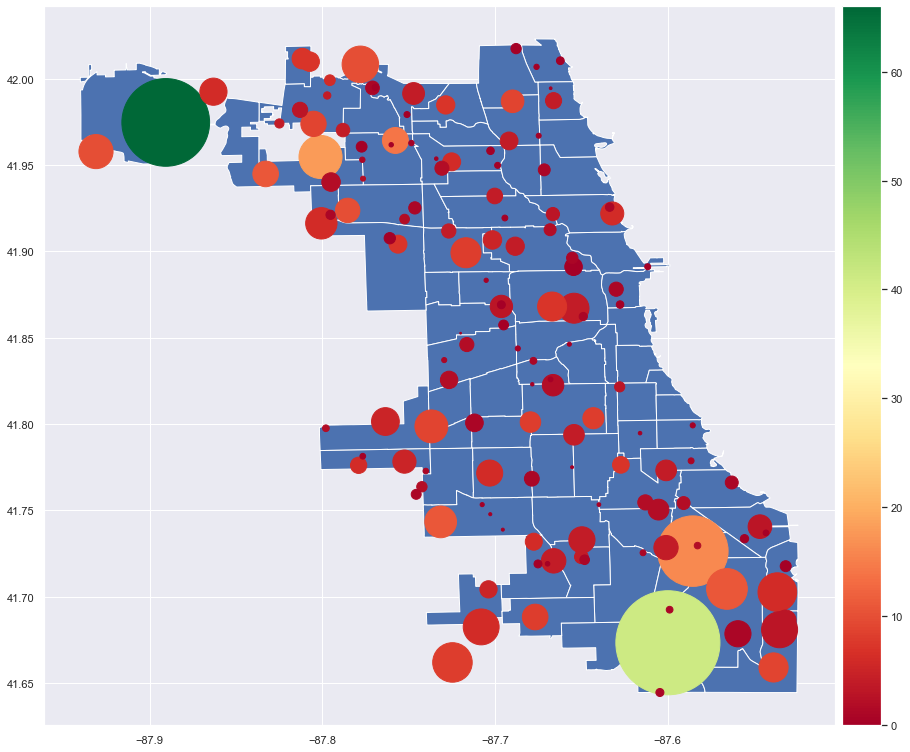

In [26]:
pvt = pd.DataFrame(merged_df.groupby(['Latitude','Longitude'])['NumMosquitos', 'WnvPresent'].sum().sort_values(by = 'NumMosquitos', ascending = False))
pvt.reset_index(inplace = True)

from mpl_toolkits.axes_grid1 import make_axes_locatable

chicago_map = gpd.read_file('../data/geo_export_fd8fe833-d02f-401f-9fd0-7b2e93a358a6.shp')

fig, ax = plt.subplots(figsize=(15, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

chicago_map.plot(ax=ax, cax=cax, legend= True);
cb = ax.scatter(pvt['Longitude'], pvt['Latitude'], s = pvt['NumMosquitos']*.5, c =pvt['WnvPresent'], cmap = 'RdYlGn')
plt.colorbar(cb, cax= cax)

#ax.scatter(pvt['Longitude'], pvt['Latitude'], s = pvt['NumMosquitos']*.1, c =pvt['WnvPresent'], marker = 'o', facecolors = 'none', color = 'red')
#ax.scatter(pvt['Longitude'], pvt['Latitude'], s = pvt['WnvPresent']*2, marker = 'o', facecolors = 'yellow', color = 'yellow')

### Let's look some data and their distribution

<AxesSubplot:>

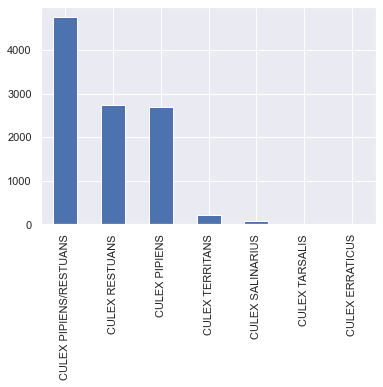

In [27]:
# Plot bar graphs of Counts of Species
merged_df['Species'].value_counts().plot.bar()

In [28]:
def plotbyyear(df, columns):
    years = np.unique(df.year)
    ncol = len(years)
    nrow = len(columns)
    fig, ax = plt.subplots(nrow, ncol, figsize=(15, 3*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        color= ['g','b','r','y']
        for j, yr in enumerate(years):
            ax[i,j].plot(df.loc[df.year==yr,col].apply(int), color=color[j])
            ax[i,0].set_ylabel(col)
            ax[0,j].set_title(yr)

In [29]:
def distplotbyyear(df, columns):
    years = np.unique(df.year)
    ncol = len(years)
    nrow = len(columns)
    fig, ax = plt.subplots(nrow, ncol, figsize=(15, 3*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        color= ['g','b','r','y']
        for j, yr in enumerate(years):
            sns.histplot(df.loc[df.year==yr,col].apply(int), color=color[j], kde=True, stat='density',ax =ax[i,j] )
            ax[0,j].set_title(yr)

In [30]:
cols = ['NumMosquitos','WnvPresent',
        'Tmax','Tmin', 'Tavg','DewPoint',
        'WetBulb','Heat','Cool', 'PrecipTotal',     'StnPressure',
        'SeaLevel', 'ResultSpeed','ResultDir','AvgSpeed']

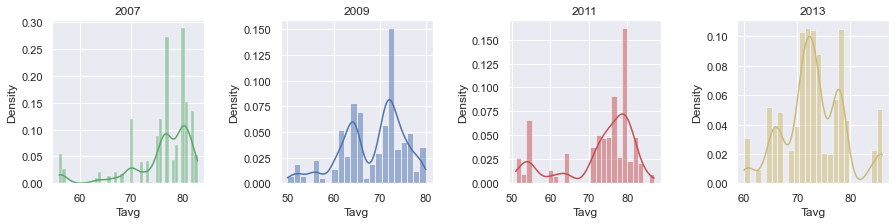

In [31]:
distplotbyyear(merged_df, ['Tavg'])

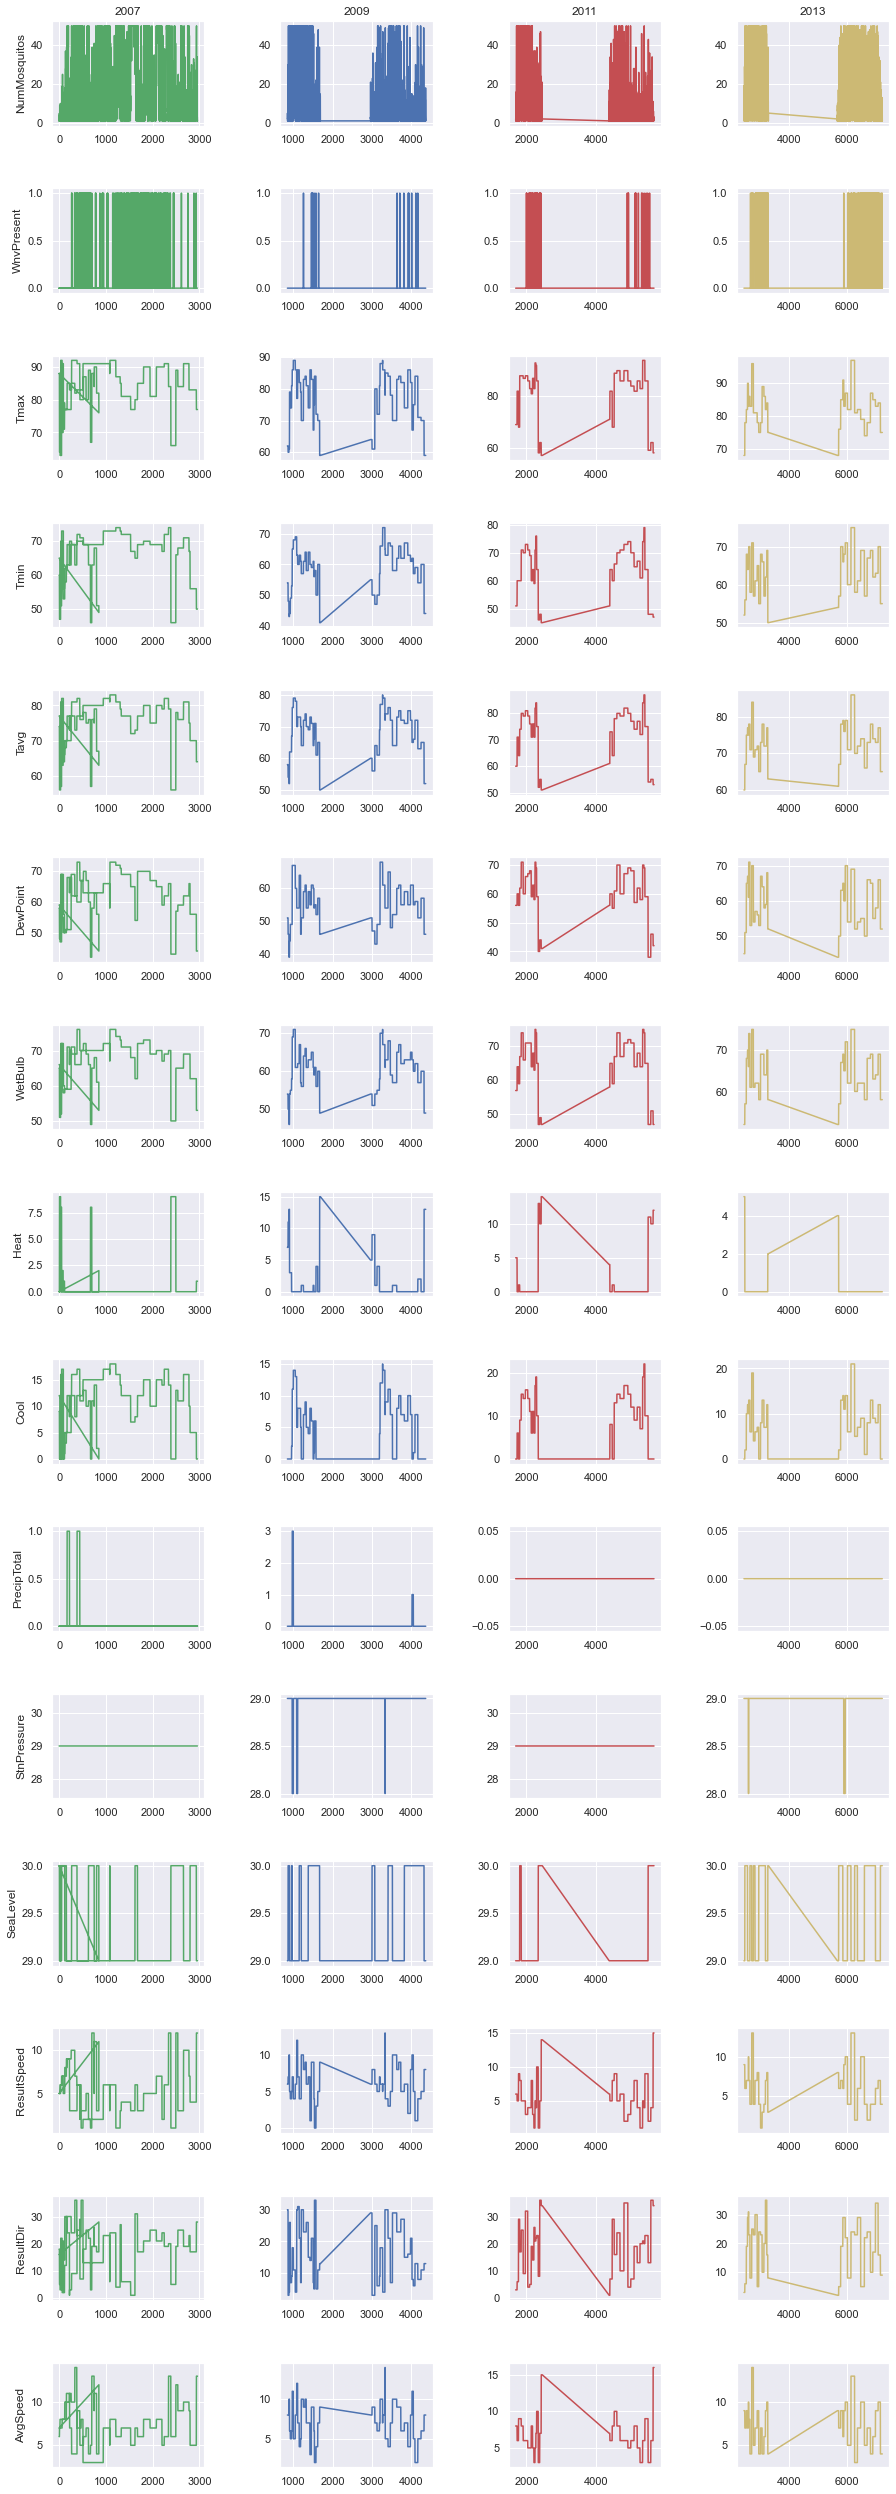

In [32]:
plotbyyear(merged_df,cols)

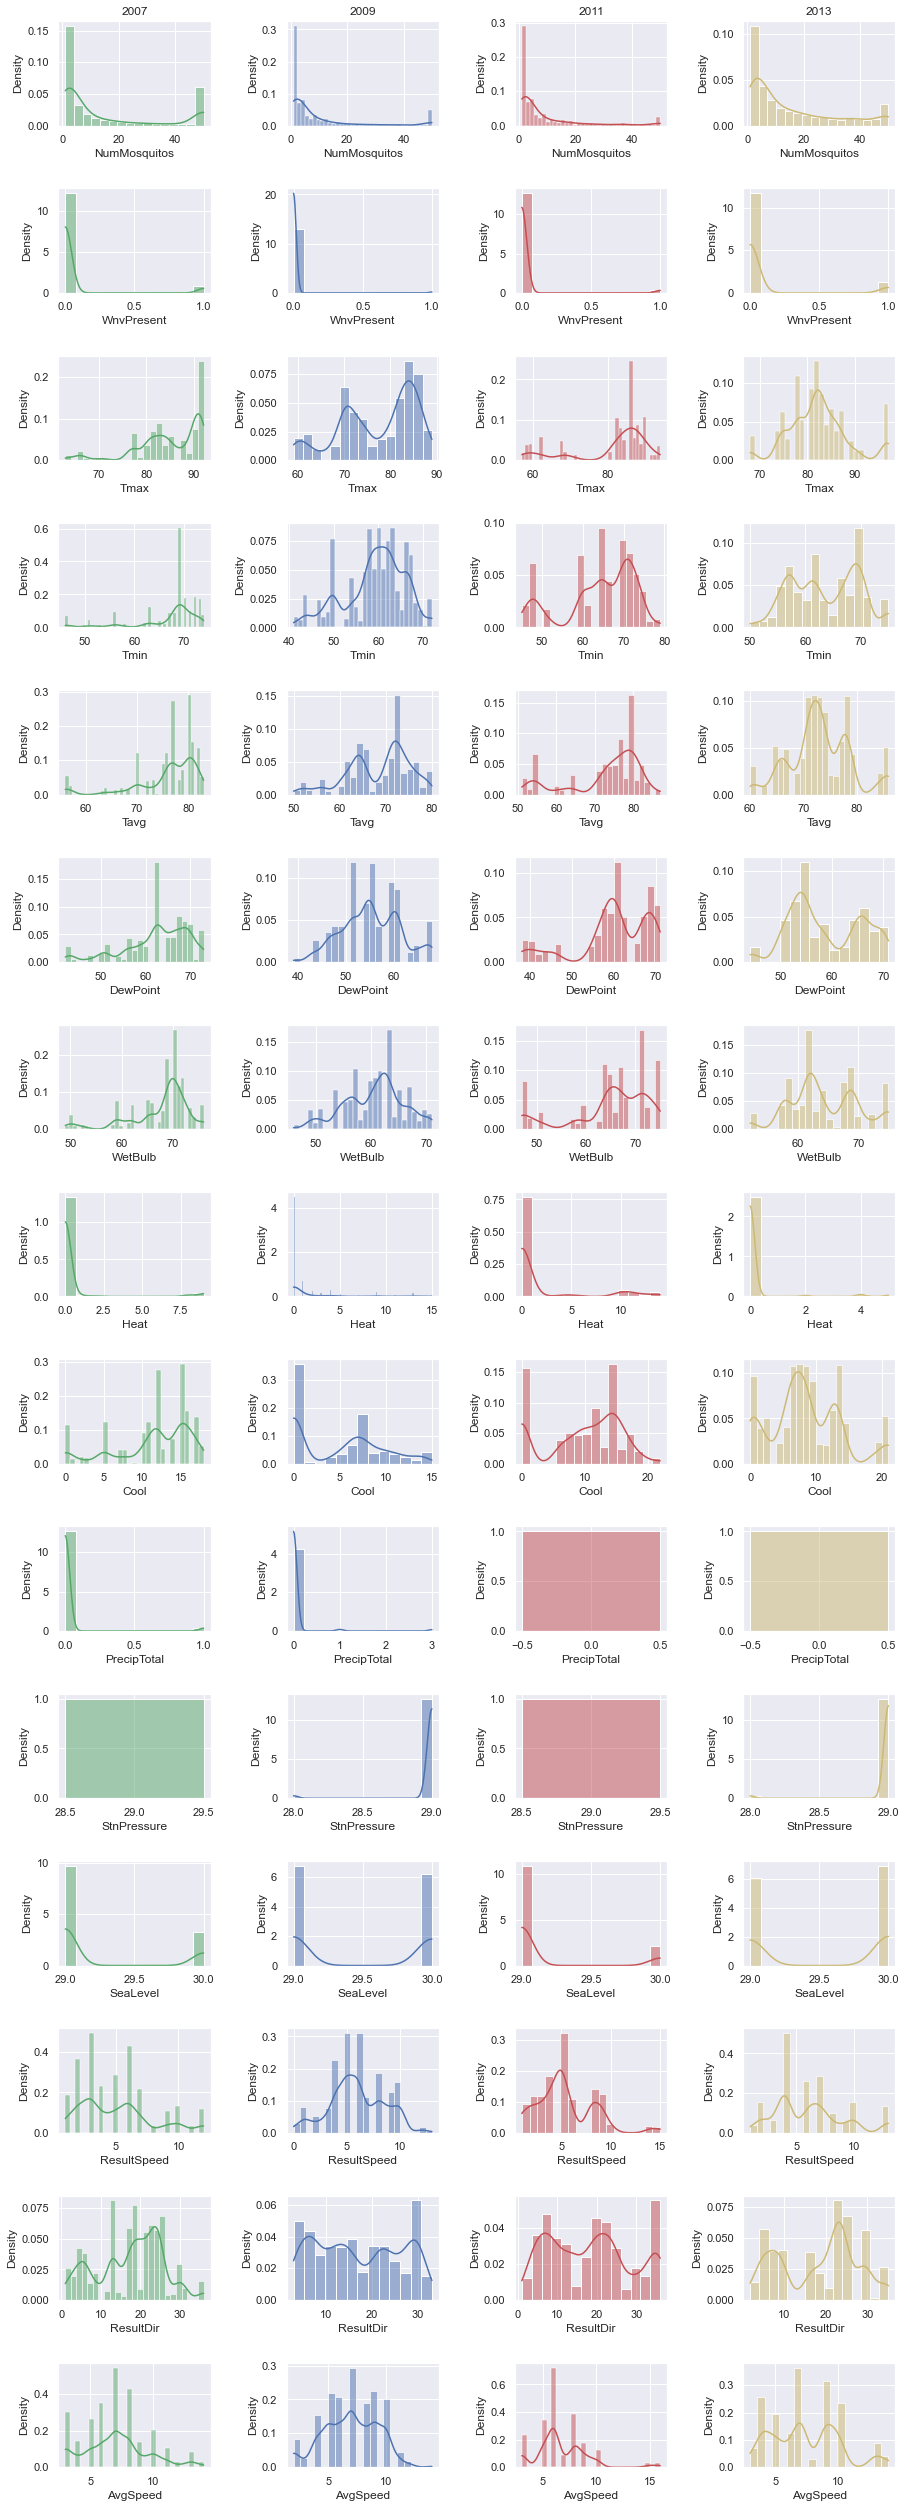

In [33]:
distplotbyyear(merged_df, cols)

### Lets check what variable impacts the presence of Virus

In [34]:
# What species is associated with the presence of virus
species_vs_virus = merged_df[['Species', 'WnvPresent']].groupby('Species', as_index= False).sum().sort_values(by = 'WnvPresent',ascending=False).reset_index(drop = True)
species_vs_virus

,Species,WnvPresent
0,CULEX PIPIENS/RESTUANS,262.0
1,CULEX PIPIENS,240.0
2,CULEX RESTUANS,49.0
3,CULEX ERRATICUS,0.0
4,CULEX SALINARIUS,0.0
5,CULEX TARSALIS,0.0
6,CULEX TERRITANS,0.0


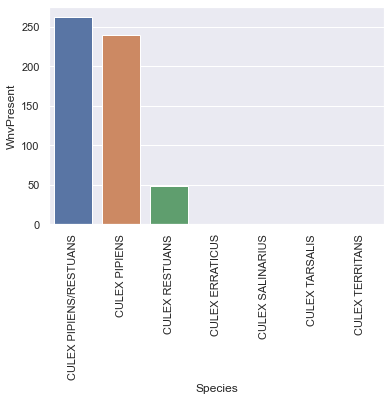

In [35]:
fig, ax = plt.subplots()
sns.barplot(data=species_vs_virus, x = 'Species', y = 'WnvPresent', ax = ax)
plt.xticks(rotation=90)
# ax2 = ax.twinx()
# merged_df['Species'].value_counts().plot.bar(ax=ax2)

plt.show()

Looks like the some mosquito species are only associated with the presence of virus but what happens if we normalize by the number of species 

In [36]:
 def boxplots(df, columns, ncol=None):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 5*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sns.boxplot(data = df, x = 'year',y = col, hue = 'WnvPresent', ax=ax, showfliers=False)
        ax.set(ylabel=col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

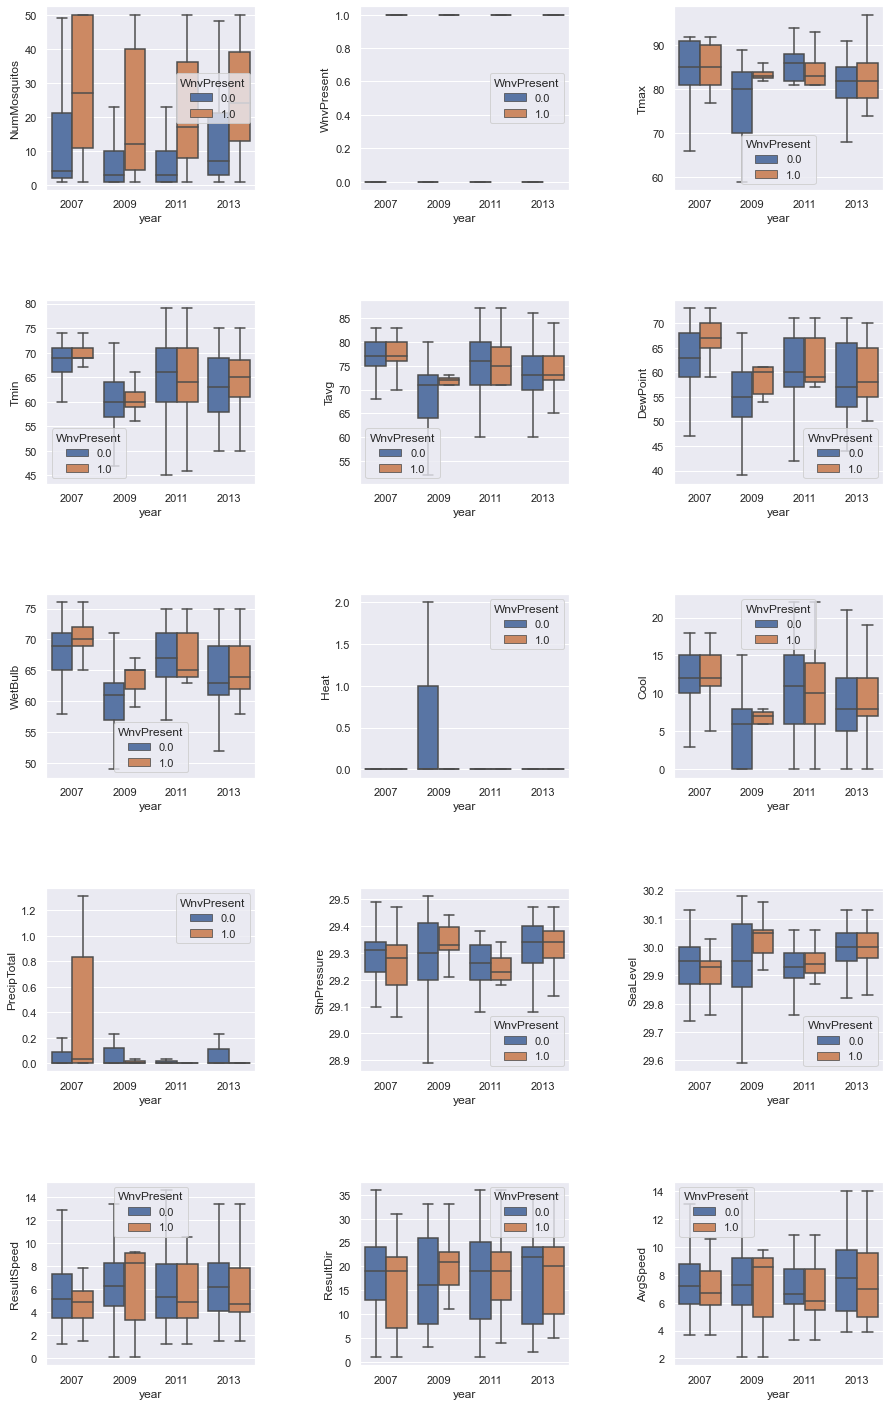

In [37]:
boxplots(merged_df, cols, ncol= 3)

### Some Key correlations Metric

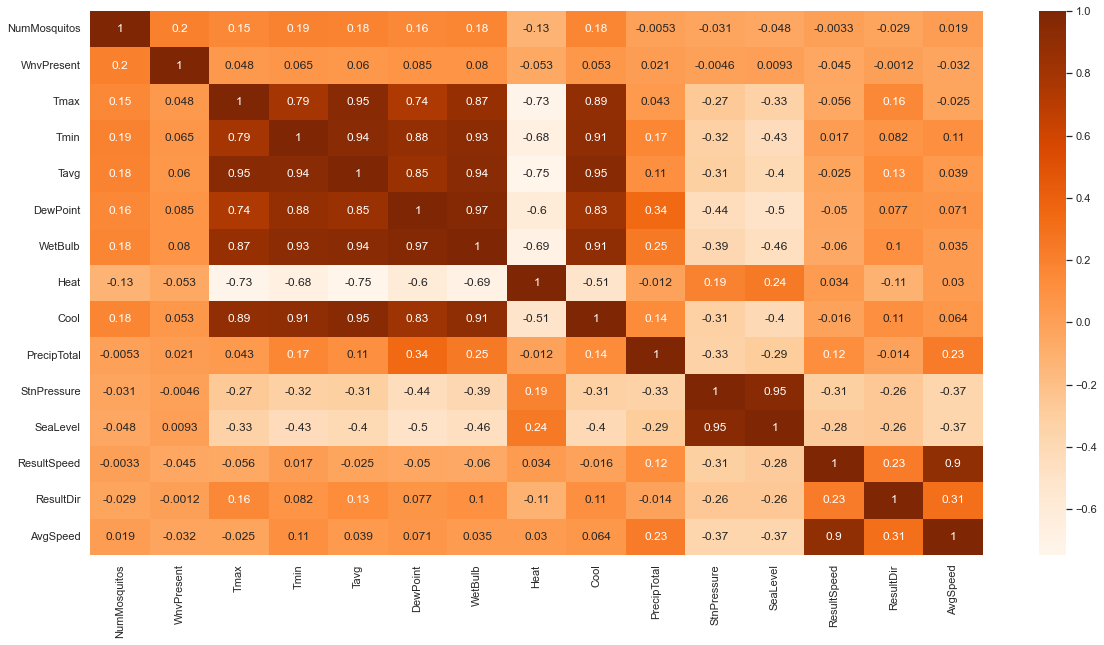

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(merged_df[cols].corr(), annot=True, cmap="Oranges" ,ax = ax)
plt.show()

### Calculate to see if correlation increases with lag

In [39]:
def corrplot(df, columns, start, stop, step, ncol=None):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil((stop-start) / (step*ncol)))
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    
    for i, x in enumerate(range(start, stop, step)):
        #print(i)
        ax = axes.flatten()[i]
        sns.heatmap((df[columns].shift(x).corr()[['WnvPresent']]-df[columns].corr()[['WnvPresent']]), annot=True, cmap="Oranges" ,ax = ax)
        ax.set(xlabel=['Shift',x])
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    

In [62]:
merged_df.to_csv('../clean_data/merged_df.csv')